In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import itertools
from scipy.optimize import linear_sum_assignment
from tqdm.auto import tqdm


/vol/bitbucket/sn1624/data-driven-framework-for-athlete-profiling/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Data Loading**

In [2]:
df_pca = pd.read_csv('df_pca.csv', index_col=0)
print("df_pca shape:", df_pca.shape)

df_full = pd.read_csv('player_features_cleaned.csv')
print("player_features_cleaned shape:", df_full.shape)

df_clean = pd.read_csv('df_clean.csv')
print("df_clean shape:", df_clean.shape)

df_pca shape: (1181, 12)
player_features_cleaned shape: (2065, 80)
df_clean shape: (1181, 80)


In [4]:
print("df_pca head:")
print(df_pca.head())

df_pca head:
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  3.123369  0.467471  3.923774  0.512249 -1.040810  0.487277  0.755278   
1  1.795306  1.173691  3.029384  0.797808  0.035705 -3.346219  1.434251   
2  3.888781 -2.652420 -2.447897  1.519520 -1.092601  2.216485  1.152343   
3  0.900337 -0.781826  0.398956 -2.405172  1.027554  1.225729  1.291634   
4  1.338887  1.907621 -2.509590 -5.214561 -0.503130 -2.644772  0.382101   

        PC8       PC9      PC10  player_number_ind                player_ind  
0 -0.066110 -0.561401 -0.167250                 24         Jacqueline Brewer  
1  0.537440 -0.574832  0.602604                 42               Jenn Carney  
2 -0.503158  0.128287 -0.542662                 44  Sarafina Arthur-Williams  
3  1.324258 -0.132066 -1.015972                 25            Jessica Harris  
4  0.561014  0.474091  0.292988                 21              Jody Chickey  


In [5]:
# pull the PC columns into a NumPy array
pc_cols   = [c for c in df_pca.columns if c.startswith('PC')]
X_cluster = df_pca[pc_cols].values


In [6]:
print(df_clean.columns)

Index(['college', 'season', 'player_number_ind', 'player_ind', 'gp_ind',
       'gs_ind', 'minutes_tot_ind', 'scoring_pts_ind', 'rebounds_tot_ind',
       'ast_ind', 'stl_ind', 'blk_ind', 'to_ind', 'pts_per40', 'reb_per40',
       'ast_per40', 'stl_per40', 'blk_per40', 'to_per40', 'eFG_pct', 'TS_pct',
       'USG_pct', 'ORB_pct', 'DRB_pct', 'AST_pct', 'AST_per_TO',
       '3pt_3pt_pct_ind', 'three_per40', 'threeA_per40', 'three_per100',
       'threeA_rate', 'DRCR', 'STL_TO_ratio', 'def_stops_per100', 'DPMR',
       'TUSG_pct', 'Gravity', 'PPT', 'Spacing', 'Assist_to_Usage', 'APC',
       'PEF', 'OEFF', 'TOV_pct', 'SEM', 'PEI', 'BoxCreation', 'OLI', 'IPM',
       'threeA_per100', '2pt_pct', 'FTr', 'PPP', 'possessions',
       'scoring_pts_per100', 'ast_per100', 'rebounds_tot_per100', 'stl_per100',
       'blk_per100', 'to_per100', 'mins_per_game', 'pts_per_game',
       'ast_per_game', 'reb_per_game', 'stl_per_game', 'blk_per_game',
       'to_per_game', 'scoring_pts_share', 'ast_share

**K-MEANS CLUSTERING**



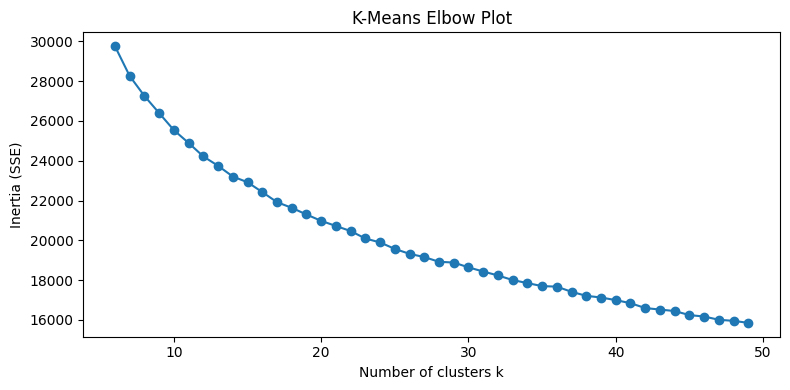

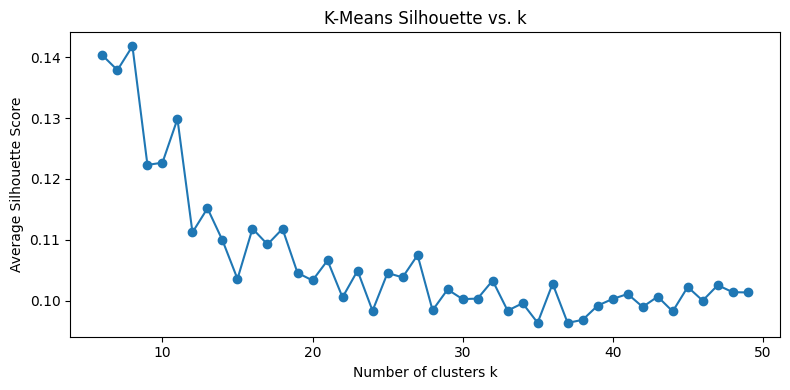

Best k by silhouette score: 8 with score 0.1418 


In [7]:
# K-Means Elbow & Silhouette Sweep

ks = list(range(6, 50))
inertias = []
sil_scores = []

for k in ks:
    # fit KMeans
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_cluster)
    
    # record inertia (sum of squared distances to centroids)
    inertias.append(km.inertia_)
    
    # record silhouette
    sil = silhouette_score(X_cluster, labels) if k > 1 else np.nan
    sil_scores.append(sil)

# Plot inertia (elbow)
plt.figure(figsize=(8,4))
plt.plot(ks, inertias, marker='o', linestyle='-')
plt.xlabel("Number of clusters k")
plt.ylabel("Inertia (SSE)")
plt.title("K-Means Elbow Plot")
plt.tight_layout()
plt.show()

# Plot silhouette
plt.figure(figsize=(8,4))
plt.plot(ks, sil_scores, marker='o', linestyle='-')
plt.xlabel("Number of clusters k")
plt.ylabel("Average Silhouette Score")
plt.title("K-Means Silhouette vs. k")
plt.tight_layout()
plt.show()

best_k = ks[np.argmax(sil_scores)]
print(f"Best k by silhouette score: {best_k} with score {max(sil_scores):.4f} ")




best_k=8  missing labels? 0
k=8, silhouette = 0.142
Centroids:
         pts_per40  eFG_pct  AST_per_TO  reb_per40  stl_per40  blk_per40
cluster                                                                 
0            -0.45    -0.32       -0.17      -0.69      -0.62      -0.28
1            -0.99    -1.00       -0.01      -0.52       0.09      -0.52
2             0.87     0.41       -0.14       1.00      -0.03       0.80
3             0.47     0.44        0.06      -0.65      -0.12      -0.44
4            -1.38    -0.24        2.31      -0.60       0.35      -0.51
5            -0.14     0.92       -0.17       0.61       0.30       0.41
6             0.76     0.13        0.57      -0.01       1.35      -0.41
7            -0.06    -0.15       -0.81       0.89      -0.38       0.75


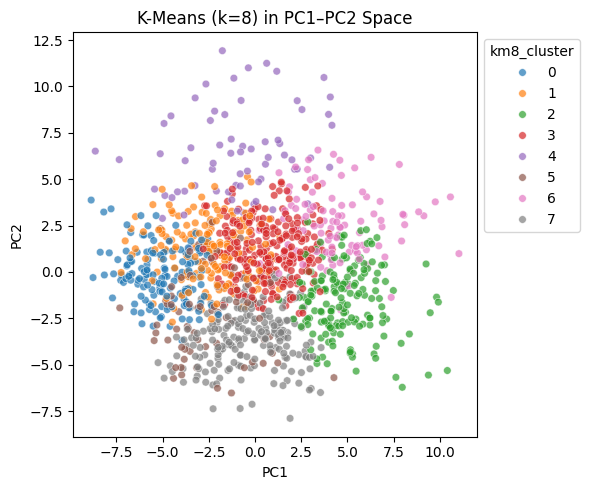

In [17]:
# K-Means Clustering

# reset both indexes to simple RangeIndex so positions match
df_clean = df_clean.reset_index(drop=True)
df_pca   = df_pca.reset_index(drop=True)

# make sure we have our PC matrix
X_cluster = df_pca[pc_cols].values

# stats we'll profile
key_stats = ['pts_per40','eFG_pct','AST_per_TO','reb_per40','stl_per40','blk_per40']


col = f'km{best_k}_cluster'

# fit & predict
km     = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels = km.fit_predict(X_cluster)

# positional assignment (no alignment)
df_pca[col]   = labels
df_clean[col] = labels  # safe: both have same length & index

# check no NaNs snuck in
n_missing = df_clean[col].isna().sum()
print(f"\n{best_k=}  missing labels? {n_missing}")

# silhouette
sil = silhouette_score(X_cluster, labels)
print(f"k={best_k}, silhouette = {sil:.3f}")

# centroids on your key stats
cent = (
    df_clean
    .groupby(col)[key_stats]
    .mean()
    .round(2)
    .rename_axis('cluster')
)
print("Centroids:")
print(cent.to_string())

# scatter in PC1–PC2
plt.figure(figsize=(6,5))
sns.scatterplot(
    x=df_pca['PC1'].values,
    y=df_pca['PC2'].values,
    hue=labels,
    palette='tab10',
    s=30,
    alpha=0.7
)
plt.title(f"K-Means (k={best_k}) in PC1–PC2 Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title=col, bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()



**ARCHETYPE MATCHING**

In [18]:
archetypes = {
    "Efficient Spot-Up Shooter": [
        ("eFG_pct", 1),
        ("3pt_3pt_pct_ind", 1),
        ("PPP", 1),
        ("FTr", 1),
        ("Spacing", 1),
    ],
    "Primary Creator / High-Usage Scorer": [
        ("USG_pct", 1),
        ("AST_per_TO", 1),
        ("pts_per40", 1),
        ("eFG_pct", 1),
        ("PPP", 1),
    ],
    "Defensive Ballhawk": [
        ("stl_per40", 1),
        ("STL_pct", 1),
        ("USG_pct", 1),
        ("AST_per_TO", 1),
        ("def_stops_per100", 1),
    ],
    "Two-Way Guard": [
        ("stl_per40", 1),
        ("PPT", 1),
        ("USG_pct", 1),
        ("AST_per_TO", 1),
        ("AST_pct", 1),
    ],
    "Versatile Facilitator / Combo Big": [
        ("AST_per_TO", 1),
        ("reb_per40", 1),
        ("blk_per40", 1),
        ("DPMR", 1),
        ("FTr", 1),
    ],
    "Rim Protector / Rebounding Big": [
        ("blk_per40", 1),
        ("DPMR", 1),
        ("def_stops_per100", 1),
        ("ORB_pct", 1),
        ("DRB_pct", 1),
    ],
    "Efficient Finisher / Low-Usage Big": [
        ("FTr", 1),
        ("eFG_pct", 1),
        ("ORB_pct", 1),
        ("PPP", 1),
        ("TS_pct", 1),
    ],
    "Glue Role Player / Hustle Forward": [
        ("reb_per40", 1),
        ("blk_per40", 1),
        ("stl_per40", 1),
        ("def_stops_per100", 1),
        ("game_score_per40", 1),
    ],
    "High-Usage Volume Big / Post Scorer": [
        ("USG_pct", 1),
        ("pts_per40", 1),
        ("FTr", 1),
        ("eFG_pct", 1),
        ("ORB_pct", 1),
    ],
    "Shooting-Creative Guard": [
        ("3pt_3pt_pct_ind", 1),
        ("AST_per_TO", 1),
        ("USG_pct", 1),
        ("eFG_pct", 1),
        ("PPP", 1),
    ],
    "Floor-Spacer Stretch Four": [
        ("3pt_3pt_pct_ind", 1),
        ("eFG_pct", 1),
        ("Spacing", 1),
        ("FTr", 1),
        ("DRB_pct", 1),
    ],
    "Pick-and-Roll Ball Handler": [
        ("AST_per_TO", 1),
        ("USG_pct", 1),
        ("AST_pct", 1),
        ("TOV_pct", -1),
        ("pts_per40", 1),
    ],
    "Roll Man / Screen Finisher": [
        ("ORB_pct", 1),
        ("FTr", 1),
        ("blk_per40", 1),
        ("reb_per40", 1),
        ("PPP", 1),
    ],
    "Isolation Scorer": [
        ("USG_pct", 1),
        ("pts_per40", 1),
        ("eFG_pct", 1),
        ("TOV_pct", -1),
        ("FTr", 1),
    ],
    "Transition Creator": [
        ("pts_per40", 1),
        ("AST_per_TO", 1),
        ("stl_per40", 1),
        ("USG_pct", 1),
        ("possessions", 1),
    ],
    "Pass-First Point Guard / Floor General": [
        ("AST_per_TO", 1),
        ("AST_pct", 1),
        ("TOV_pct", -1),
        ("USG_pct", 1),
        ("stl_per40", 1),
    ],
    "Perimeter Shutdown Defender": [
        ("def_stops_per100", 1),
        ("DPMR", 1),
        ("stl_per40", 1),
        ("STL_TO_ratio", 1),
        ("DRB_pct", 1),
    ],
    "Secondary Creator / Off-Ball Facilitator": [
        ("AST_per_TO", 1),
        ("BoxCreation", 1),
        ("Spacing", 1),
        ("PPP", 1),
        ("3pt_3pt_pct_ind", 1),
    ],
    "Slasher / Cutter": [
        ("FTr", 1),
        ("pts_per40", 1),
        ("stl_per40", 1),
        ("AST_per_TO", 1),
        ("eFG_pct", 1),
    ],
    "Second-Chance Specialist": [
        ("ORB_pct", 1),
        ("reb_per40", 1),
        ("pts_per40", 1),
        ("PPP", 1),
        ("game_score_per40", 1),
    ],
    "Playmaking Wing": [
        ("AST_per_TO", 1),
        ("USG_pct", 1),
        ("3pt_3pt_pct_ind", 1),
        ("stl_per40", 1),
        ("PPP", 1),
    ],
    "Gravity/Space Creator": [
        ("Gravity", 1),
        ("Spacing", 1),
        ("threeA_rate", 1),
        ("3pt_3pt_pct_ind", 1),
        ("PPT", 1),
    ],
    "Two-Way Wing": [
        ("eFG_pct", 1),
        ("def_stops_per100", 1),
        ("stl_per40", 1),
        ("reb_per40", 1),
        ("USG_pct", 1),
    ],
    "Corner Specialist": [
        ("3pt_3pt_pct_ind", 1),
        ("Spacing", 1),
        ("eFG_pct", 1),
        ("PPT", 1),
        ("PPP", 1),
    ],
    "Deep Range Specialist": [
        ("3pt_3pt_pct_ind", 1),
        ("eFG_pct", 1), 
        ("Gravity", 1),
        ("threeA_rate", 1),
        ("Spacing", 1),
    ],
    "Floor General": [
        ("AST_per_TO", 1),
        ("AST_pct", 1),
        ("USG_pct", 1),
        ("Spacing", 1),
        ("TOV_pct", -1),
    ],
    "Screen Setter / Roll-Pop Facilitator": [
        ("BoxCreation", 1),
        ("Spacing", 1),
        ("ORB_pct", 1),
        ("AST_per_TO", 1),
        ("FTr", 1),
    ],
    "Off-Ball Movement Creator": [
        ("Spacing", 1),
        ("BoxCreation", 1),
        ("3pt_3pt_pct_ind", 1),
        ("AST_per_TO", 1),
        ("PPP", 1),
    ],
    "Volume Distributor": [
        ("AST_pct", 1),
        ("AST_per_TO", 1),
        ("USG_pct", 1),
        ("pts_per40", 1),
        ("TOV_pct", -1),
    ],
    "Effort Defensive Role Player": [
        ("stl_per40", 1),
        ("reb_per40", 1),
        ("def_stops_per100", 1),
        ("DPMR", 1),
        ("min_share", -1),
    ],
    "Low-Usage Secure Role Player": [
        ("TOV_pct", -1),
        ("min_share", -1),
        ("possessions", -1),
        ("def_stops_per100", 1),
        ("reb_per40", 1),
    ],
    "Offensive Liability / Role Defensive Specialist": [
        ("pts_per40", -1),
        ("eFG_pct", -1),
        ("TS_pct", -1),
        ("PPP", -1),
        ("def_stops_per100", 1),  
        ("DPMR", 1),
    ],
    "Roll Man / Screen Finisher": [
        ("reb_per40", 1),
        ("FTr", 1),
        ("threeA_rate", -1),
        ("reb_per40", 1),
        ("Spacing", -1),
],
"Non-Impact Role Player": [
    ("pts_per40", -1),
    ("eFG_pct", -1),
    ("TS_pct", -1),
    ("PPP", -1),
    ("game_score_per40", -1),
],

}


In [19]:
import numpy as np
import pandas as pd
from scipy.optimize import linear_sum_assignment

# ----- Inputs you already have -----
# df_clean: your dataframe
# archetypes: dict[str, list[(metric, sign)]]
# best_k: chosen k
cluster_col   = f'km{best_k}_cluster'
cluster_labels = np.sort(df_clean[cluster_col].unique())

# 1) Collect the metrics we actually need and z-score them (vectorized)
all_metrics = sorted({m for lst in archetypes.values() for (m, _) in lst})
present_metrics = [m for m in all_metrics if m in df_clean.columns]

X = df_clean[present_metrics].astype(float).copy()
col_means = X.mean(axis=0, skipna=True)
X = X.fillna(col_means)
col_stds = X.std(axis=0, ddof=0).replace(0.0, 1.0)  # avoid div-by-zero
Z = (X - col_means) / col_stds  # global z-score

# 2) Cluster centroids (mean z-score per metric)
#    Use the series version of groupby to avoid adding cluster column to Z
cluster_centroids = Z.groupby(df_clean[cluster_col]).mean()   # shape: (n_clusters, n_metrics)
cluster_centroids = cluster_centroids.reindex(index=cluster_labels)

# 3) Build a rectangular score matrix for all clusters × all archetypes (vectorized)
def archetype_weights(n, base=0.5):
    # decreasing geometric weights from most-important → least-important
    raw = np.array([base**i for i in range(n)][::-1], dtype=float)
    return raw / raw.sum()

arch_names = list(archetypes.keys())
score_matrix = np.full((len(cluster_labels), len(arch_names)), -1e3, dtype=float)  # default if no overlap

metrics_cols = cluster_centroids.columns

for j, arch in enumerate(arch_names):
    feats = [m for m, _ in archetypes[arch] if m in metrics_cols]
    if not feats:
        continue
    # indices in the archetype's list that actually exist
    idxs_in_arch = [i for i, (m, _) in enumerate(archetypes[arch]) if m in metrics_cols]
    # weight mask (renormalized over present features)
    w_full = archetype_weights(len(archetypes[arch]))
    w = w_full[idxs_in_arch]
    w = w / w.sum()

    # signs aligned to feats
    signs = np.array([s for (m, s) in archetypes[arch] if m in metrics_cols], dtype=float)
    # Z-scores for all clusters over these feats
    C = cluster_centroids.loc[:, feats].to_numpy()  # shape: (n_clusters, len(feats))
    # weighted sum per cluster
    # multiply by sign (direction) then dot with weights
    scores = (C * signs) @ w
    score_matrix[:, j] = scores

# 4) Solve one rectangular assignment: each cluster → a unique archetype
#    We want to maximize score, so minimize negative score
cost = -score_matrix
row_ind, col_ind = linear_sum_assignment(cost)  # works with rectangular matrices

best_mapping = {int(cluster_labels[r]): arch_names[c] for r, c in zip(row_ind, col_ind)}
best_total   = score_matrix[row_ind, col_ind].sum()

print("Best total score:", best_total)
print("Cluster → Archetype")
for cl in cluster_labels:
    arch = best_mapping.get(int(cl), None)
    print(f"{cl}: {arch}")

# 5) Optional: report confidence (row-wise margin between best and second-best)
row_best = score_matrix.max(axis=1)
row_second = np.partition(score_matrix, -2, axis=1)[:, -2]
confidence = {int(cluster_labels[i]): float(row_best[i] - row_second[i]) for i in range(len(cluster_labels))}

print("\nConfidence margins:")
for cl in cluster_labels:
    print(f"{cl}: {confidence[int(cl)]:.3f}")


Best total score: 8.645231296455929
Cluster → Archetype
0: Floor General
1: Non-Impact Role Player
2: Rim Protector / Rebounding Big
3: Deep Range Specialist
4: Two-Way Guard
5: Corner Specialist
6: Transition Creator
7: Roll Man / Screen Finisher

Confidence margins:
0: 0.200
1: 0.859
2: 0.170
3: 0.302
4: 0.586
5: 0.145
6: 0.258
7: 0.480


In [20]:
# new scoring system from 0-100%

assigned = []
for cl, arch in best_mapping.items():
    raw = score_matrix.at[cl, arch]
    # Theoretical “perfect” is a weighted‐sum of +1 z‐score on every metric → 1.0
    pct = max(0.0, min(raw / 1.0, 1.0)) * 100
    assigned.append({
        "cluster":    cl,
        "archetype":  arch,
        "raw_score":  raw,
        "match_%":    f"{pct:.1f}%"
    })

print(f"\nCluster → Archetype (with match % of a perfect 1σ fit):")
display(pd.DataFrame(assigned).sort_values("cluster"))


AttributeError: 'numpy.ndarray' object has no attribute 'at'

In [ ]:
# Settings
cluster_col   = f'km{best_k}_cluster'
cluster_labels = sorted(df_clean[cluster_col].unique())

# Global z-score on all needed metrics
all_metrics      = sorted({m for mets in archetypes.values() for m,_ in mets})
present_metrics  = [m for m in all_metrics if m in df_clean.columns]

zdf = pd.DataFrame(index=df_clean.index)
for m in present_metrics:
    if df_clean[m].nunique(dropna=True) > 1:
        zdf[m] = zscore(df_clean[m].fillna(df_clean[m].mean()))
    else:
        zdf[m] = 0.0

# Compute cluster centroids
zdf[cluster_col] = df_clean[cluster_col]
cluster_centroids = zdf.groupby(cluster_col).mean()

# Weight factory
def archetype_weights(n, base=0.5):
    raw = [base**i for i in range(n)][::-1]
    arr = np.array(raw, dtype=float)
    return arr / arr.sum()

# Build score matrix
score_matrix = pd.DataFrame(index=cluster_labels,
                            columns=list(archetypes.keys()),
                            dtype=float)

for arch_name, metric_list in archetypes.items():
    weights_full = archetype_weights(len(metric_list))
    for cl in cluster_labels:
        centroid = cluster_centroids.loc[cl]
        vals, wts = [], []
        for idx, (m, sign) in enumerate(metric_list):
            if m not in centroid.index:
                continue
            v = centroid[m] * sign
            vals.append(v)
            wts.append(weights_full[idx])
        if not vals:
            score = -1e3
        else:
            w_arr = np.array(wts)
            v_arr = np.array(vals)
            w_norm = w_arr / w_arr.sum()
            score = float(np.dot(w_norm, v_arr))
        score_matrix.at[cl, arch_name] = score

# Unique assignment over archetype subsets
arch_keys   = list(archetypes.keys())
n_clusters  = len(cluster_labels)
assert n_clusters <= len(arch_keys), "Need ≥ as many archetypes as clusters."

subsets = list(itertools.combinations(arch_keys, n_clusters))
print(f"Evaluating {len(subsets)} possible subsets of {n_clusters} archetypes…")

best_total   = -np.inf
best_subset  = None
best_mapping = None

for subset in subsets:
    cost = -score_matrix.loc[cluster_labels, list(subset)].to_numpy()
    rows, cols = linear_sum_assignment(cost)
    tot = -cost[rows, cols].sum()
    if tot > best_total:
        best_total   = tot
        best_subset  = subset
        best_mapping = {cluster_labels[r]: subset[c] for r,c in zip(rows,cols)}

# Report
print(f"\n Best total match score: {best_total:.3f}")
print("Selected archetypes subset:", best_subset)

assigned = [
    {"cluster": cl, "archetype": arch, "match_score": score_matrix.at[cl,arch]}
    for cl, arch in best_mapping.items()
]
display(pd.DataFrame(assigned).sort_values("cluster", ascending=True))


Evaluating 13884156 possible subsets of 8 archetypes…


KeyboardInterrupt: 

In [ ]:
# new scoring system from 0-100%

assigned = []
for cl, arch in best_mapping.items():
    raw = score_matrix.at[cl, arch]
    # Theoretical “perfect” is a weighted‐sum of +1 z‐score on every metric → 1.0
    pct = max(0.0, min(raw / 1.0, 1.0)) * 100
    assigned.append({
        "cluster":    cl,
        "archetype":  arch,
        "raw_score":  raw,
        "match_%":    f"{pct:.1f}%"
    })

print(f"\nCluster → Archetype (with match % of a perfect 1σ fit):")
display(pd.DataFrame(assigned).sort_values("cluster"))


In [ ]:
# Settings
cluster_col   = f'km{best_k}_cluster'
cluster_labels = sorted(df_clean[cluster_col].unique())

# Global z-score on all needed metrics
all_metrics      = sorted({m for mets in archetypes.values() for m,_ in mets})
present_metrics  = [m for m in all_metrics if m in df_clean.columns]


# Global z-score on all needed metrics (with progress)
zdf = pd.DataFrame(index=df_clean.index)
for m in tqdm(present_metrics, desc="Z-scoring metrics"):
    if df_clean[m].nunique(dropna=True) > 1:
        zdf[m] = zscore(df_clean[m].fillna(df_clean[m].mean()))
    else:
        zdf[m] = 0.0

# Compute cluster centroids
zdf[cluster_col] = df_clean[cluster_col]
cluster_centroids = zdf.groupby(cluster_col).mean()

# Weight factory
def archetype_weights(n, base=0.5):
    raw = [base**i for i in range(n)][::-1]
    arr = np.array(raw, dtype=float)
    return arr / arr.sum()

# Build score matrix (with progress)
score_matrix = pd.DataFrame(index=cluster_labels,
                            columns=list(archetypes.keys()),
                            dtype=float)

for arch_name, metric_list in tqdm(archetypes.items(), desc="Scoring archetypes"):
    weights_full = archetype_weights(len(metric_list))
    for cl in tqdm(cluster_labels, desc="Clusters", leave=False):
        centroid = cluster_centroids.loc[cl]
        vals, wts = [], []
        for idx, (m, sign) in enumerate(metric_list):
            if m not in centroid.index:
                continue
            v = centroid[m] * sign
            vals.append(v)
            wts.append(weights_full[idx])
        if not vals:
            score = -1e3
        else:
            w_arr = np.array(wts)
            v_arr = np.array(vals)
            w_norm = w_arr / w_arr.sum()
            score = float(np.dot(w_norm, v_arr))
        score_matrix.at[cl, arch_name] = score

# Unique assignment over archetype subsets (with progress)
arch_keys   = list(archetypes.keys())
n_clusters  = len(cluster_labels)
assert n_clusters <= len(arch_keys), "Need ≥ as many archetypes as clusters."

subsets = list(itertools.combinations(arch_keys, n_clusters))
print(f"Evaluating {len(subsets)} possible subsets of {n_clusters} archetypes…")

best_total   = -np.inf
best_subset  = None
best_mapping = None

for subset in tqdm(subsets, desc="Evaluating subsets"):
    cost = -score_matrix.loc[cluster_labels, list(subset)].to_numpy()
    rows, cols = linear_sum_assignment(cost)
    tot = -cost[rows, cols].sum()
    if tot > best_total:
        best_total   = tot
        best_subset  = subset
        best_mapping = {cluster_labels[r]: subset[c] for r,c in zip(rows,cols)}


Scoring archetypes: 100%|██████████| 33/33 [00:00<00:00, 132.33it/s]

Evaluating 13884156 possible subsets of 8 archetypes…


Evaluating subsets:   7%|▋         | 963459/13884156 [05:20<1:11:41, 3003.45it/s]


KeyboardInterrupt: 

In [ ]:
# new scoring system from 0-100%

assigned = []
for cl, arch in best_mapping.items():
    raw = score_matrix.at[cl, arch]
    # Theoretical “perfect” is a weighted‐sum of +1 z‐score on every metric → 1.0
    pct = max(0.0, min(raw / 1.0, 1.0)) * 100
    assigned.append({
        "cluster":    cl,
        "archetype":  arch,
        "raw_score":  raw,
        "match_%":    f"{pct:.1f}%"
    })

print(f"\nCluster → Archetype (with match % of a perfect 1σ fit):")
display(pd.DataFrame(assigned).sort_values("cluster"))



Cluster → Archetype (with match % of a perfect 1σ fit):


,cluster,archetype,raw_score,match_%
0,0,Floor General,0.859528,86.0%
1,1,Rim Protector / Rebounding Big,1.096728,100.0%
2,2,Non-Impact Role Player,1.025748,100.0%
3,3,Deep Range Specialist,0.819206,81.9%
4,4,Two-Way Guard,1.391365,100.0%
5,5,Roll Man / Screen Finisher,0.942320,94.2%
